In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [10]:
# ДЗ 2
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

In [11]:
image = cv2.imread('img.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

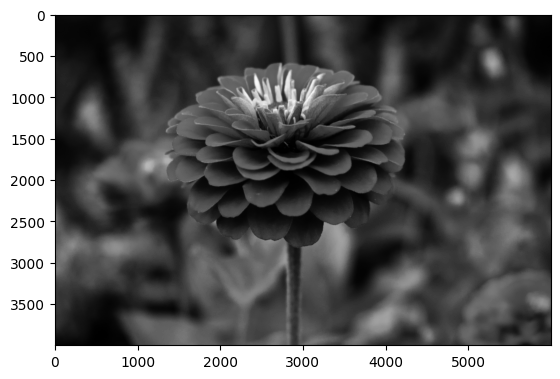

In [12]:
plt.imshow(image_gray, cmap="gray")

Функция для оценки качества фильтрации

In [13]:
def evaluate_filter(original, filtered):
    psnr_value = psnr(original, filtered)
    ssim_value = ssim(original, filtered)
    return psnr_value, ssim_value

1. Зашумить изображение при помощи шума гаусса, постоянного шума.

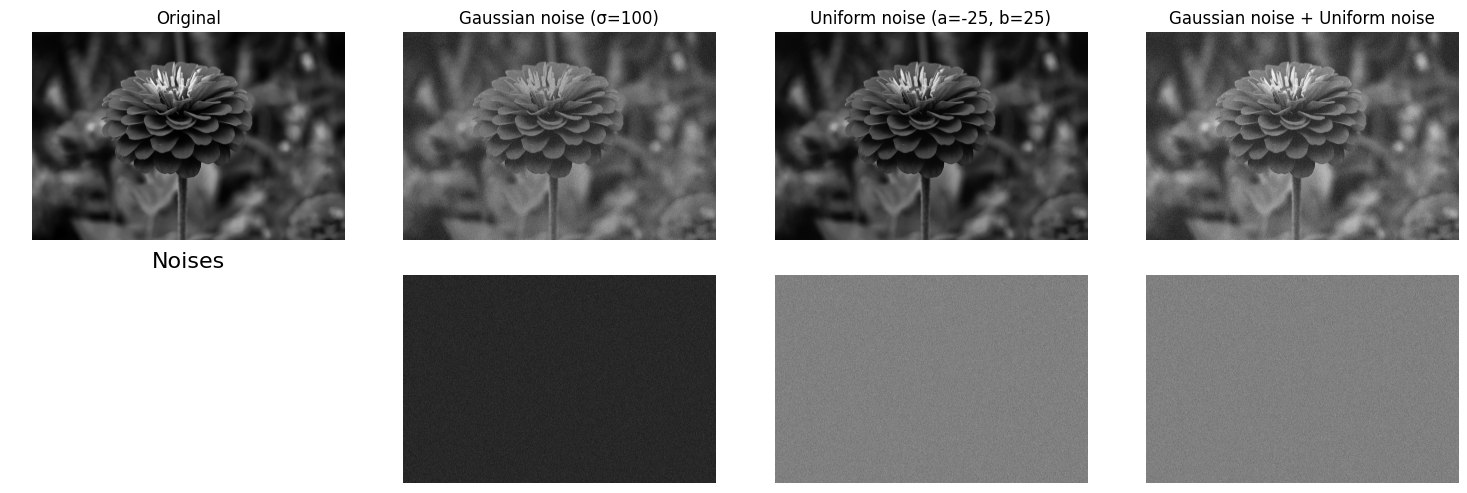

Original vs Original with gaussian noise.
	PSNR: 12.423198364339976, SSIM: 0.02788666050214338
Original vs Original with uniform noise.
	PSNR: 25.15049208754613, SSIM: 0.2983244793719801
Original vs Original with gaussian & uniform noises.
	PSNR: 11.464839946789231, SSIM: 0.024275788532746558


In [14]:
# save noises images
images_noise = {}

fig, axes = plt.subplots(2, 4, figsize=(15, 5))

axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[1, 0].set_title('Noises', fontsize=16, pad=5)
axes[1, 0].axis('off')

# create gauss noise
mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)

axes[1, 1].imshow(noise_gauss, cmap='gray')
axes[1, 1].axis('off')

# create uniform noise
a, b = -25, 25
noise_uniform = np.random.uniform(a, b, image_gray.shape)
axes[1, 2].imshow(noise_uniform, cmap='gray')
axes[1, 2].axis('off')

# create gausse + uniform noise
noise_gauss_uniform = noise_gauss + noise_uniform
axes[1, 3].imshow(noise_uniform, cmap='gray')
axes[1, 3].axis('off')

# original + gauss noise
image_noise_gauss = np.clip(image_gray + noise_gauss, 0, 255).astype(np.uint8)
images_noise[f'Gaussian noise (σ={stddev})'] = image_noise_gauss

# original + uniform noise
image_noise_uniform = np.clip(image_gray + noise_uniform, 0, 255).astype(np.uint8)
images_noise[f'Uniform noise (a={a}, b={b})'] = image_noise_uniform

# original + gauss noise + uniform noise
image_noise_gauss_uniform = np.clip(image_gray + noise_gauss_uniform, 0, 255).astype(np.uint8)
images_noise[f'Gaussian noise + Uniform noise'] = image_noise_gauss_uniform

for col, key in enumerate(images_noise, start=1):
    axes[0, col].imshow(images_noise[key], cmap='gray')
    axes[0, col].set_title(key)
    axes[0, col].axis('off')

plt.tight_layout()
plt.show()

print("Original vs Original with gaussian noise.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_gauss)))
print("Original vs Original with uniform noise.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_uniform)))
print("Original vs Original with gaussian & uniform noises.")
print("\tPSNR: {0}, SSIM: {1}".format(*evaluate_filter(image_gray, image_noise_gauss_uniform)))

2. Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.

In [15]:
results = {}

filters = [
    ('Median', cv2.medianBlur),
    ('Gaussian', cv2.GaussianBlur),
    ('Bilateral', cv2.bilateralFilter),
    ('NlMeans', cv2.fastNlMeansDenoising)
]

# 1. Median blurd
kernel_sizes = [3, 5, 7, 9]
for size in kernel_sizes:
    med_gauss = cv2.medianBlur(image_noise_gauss, size)
    psnr_val, ssim_val = evaluate_filter(image_gray, med_gauss)
    results[f'Median (gaussian noise, kernel={size})'] = (med_gauss, psnr_val, ssim_val)

    med_unif = cv2.medianBlur(image_noise_uniform, size)
    psnr_val, ssim_val = evaluate_filter(image_gray, med_unif)
    results[f'Median (uniform noise, kernel={size})'] = (med_unif, psnr_val, ssim_val)

    med_gauss_unif = cv2.medianBlur(image_noise_gauss_uniform, size)
    psnr_val, ssim_val = evaluate_filter(image_gray, med_gauss_unif)
    results[f'Median (gaussian&uniform noise, kernel={size})'] = (med_gauss_unif, psnr_val, ssim_val)


# 2. Gaussian blur
kernel_sizes = [3, 5, 7]
sigmas = [1, 2, 3]
for size in kernel_sizes:
    for sigma in sigmas:
        gauss_gauss = cv2.GaussianBlur(image_noise_gauss, (size, size), sigma)
        psnr_val, ssim_val = evaluate_filter(image_gray, gauss_gauss)
        results[f'Gaussian (gaussian noise, kernel={size}, σ={sigma})'] = (gauss_gauss, psnr_val, ssim_val)

        gauss_unif = cv2.GaussianBlur(image_noise_uniform, (size, size), sigma)
        psnr_val, ssim_val = evaluate_filter(image_gray, gauss_unif)
        results[f'Gaussian (uniform noise, kernel={size}, σ={sigma})'] = (gauss_unif, psnr_val, ssim_val)

        gauss_gauss_unif = cv2.GaussianBlur(image_noise_gauss_uniform, (size, size), sigma)
        psnr_val, ssim_val = evaluate_filter(image_gray, gauss_gauss_unif)
        results[f'Gaussian (gaussian&uniform noise, kernel={size}, σ={sigma})'] = (gauss_gauss_unif, psnr_val, ssim_val)

# 3. Bilateral filter
d_values = [5, 9, 15]
sigma_color_values = [25, 50, 75]
sigma_space_values = [25, 50, 75]

for d in d_values:
    for sigma_color in sigma_color_values:
        for sigma_space in sigma_space_values:
            bilateral_gauss = cv2.bilateralFilter(image_noise_gauss, d, sigma_color, sigma_space)
            psnr_val, ssim_val = evaluate_filter(image_gray, bilateral_gauss)
            results[f'Bilateral (gaussian noise, d={d}, σ_color={sigma_color}, σ_space={sigma_space})'] = (bilateral_gauss, psnr_val, ssim_val)

            bilateral_unif = cv2.bilateralFilter(image_noise_uniform, d, sigma_color, sigma_space)
            psnr_val, ssim_val = evaluate_filter(image_gray, bilateral_unif)
            results[f'Bilateral (uniform noise, d={d}, σ_color={sigma_color}, σ_space={sigma_space})'] = (bilateral_unif, psnr_val, ssim_val)

            bilateral_gauss_unif = cv2.bilateralFilter(image_noise_gauss_uniform, d, sigma_color, sigma_space)
            psnr_val, ssim_val = evaluate_filter(image_gray, bilateral_gauss_unif)
            results[f'Bilateral (gaussian&uniform noise, d={d}, σ_color={sigma_color}, σ_space={sigma_space})'] = (bilateral_gauss_unif, psnr_val, ssim_val)

# 4. No-local Means
h_values = [10, 20, 30]
template_window_sizes = [7, 11]
search_window_sizes = [21, 35]

for h in h_values:
    for template_size in template_window_sizes:
        for search_size in search_window_sizes:
            nlm_gauss = cv2.fastNlMeansDenoising(image_noise_gauss, None, h, template_size, search_size)
            psnr_val, ssim_val = evaluate_filter(image_gray, nlm_gauss)
            results[f'No-local Means (gaussian noise, h={h}, template={template_size}, search={search_size})'] = (nlm_gauss, psnr_val, ssim_val)

            nlm_unif = cv2.fastNlMeansDenoising(image_noise_uniform, None, h, template_size, search_size)
            psnr_val, ssim_val = evaluate_filter(image_gray, nlm_unif)
            results[f'No-local Means (uniform noise, h={h}, template={template_size}, search={search_size})'] = (nlm_unif, psnr_val, ssim_val)

            nlm_gauss_unif = cv2.fastNlMeansDenoising(image_noise_gauss_uniform, None, h, template_size, search_size)
            psnr_val, ssim_val = evaluate_filter(image_gray, nlm_gauss_unif)
            results[f'No-local Means (gaussian&uniform noise, h={h}, template={template_size}, search={search_size})'] = (nlm_gauss_unif, psnr_val, ssim_val)


best_results = {}
for key in results:
    noise_type = "gaussian&uniform" if "gaussian&uniform" in key else ("uniform" if "uniform" in key else "gaussian")
    filter_type = key.split(' ')[0]

    if (noise_type, filter_type) not in best_results:
        best_results[(noise_type, filter_type)] = (key, results[key][1], results[key][2])
    else:
        # Compare with PSNR
        if results[key][1] > best_results[(noise_type, filter_type)][1]:
            best_results[(noise_type, filter_type)] = (key, results[key][1], results[key][2])


print("The best results from filters:")
print("-" * 80)
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    print(f"{filter_type} filter for {noise_type} noise: PSNR = {psnr_val:.2f}, SSIM = {ssim_val:.4f}")
    print(f"\tParametrs: {key}\n")

The best results from filters:
--------------------------------------------------------------------------------
Median filter for gaussian noise: PSNR = 29.15, SSIM = 0.7178
	Parametrs: Median (gaussian noise, kernel=9)

Median filter for uniform noise: PSNR = 35.14, SSIM = 0.8070
	Parametrs: Median (uniform noise, kernel=9)

Median filter for gaussian&uniform noise: PSNR = 22.74, SSIM = 0.6683
	Parametrs: Median (gaussian&uniform noise, kernel=9)

Gaussian filter for gaussian noise: PSNR = 17.48, SSIM = 0.4905
	Parametrs: Gaussian (gaussian noise, kernel=7, σ=3)

Gaussian filter for uniform noise: PSNR = 35.80, SSIM = 0.8216
	Parametrs: Gaussian (uniform noise, kernel=7, σ=3)

Gaussian filter for gaussian&uniform noise: PSNR = 16.22, SSIM = 0.4566
	Parametrs: Gaussian (gaussian&uniform noise, kernel=7, σ=3)

Bilateral filter for gaussian noise: PSNR = 17.30, SSIM = 0.1497
	Parametrs: Bilateral (gaussian noise, d=15, σ_color=75, σ_space=75)

Bilateral filter for uniform noise: PSNR = 3

3. Выяснить, какой фильтр показал лучший результат фильтрации шума.

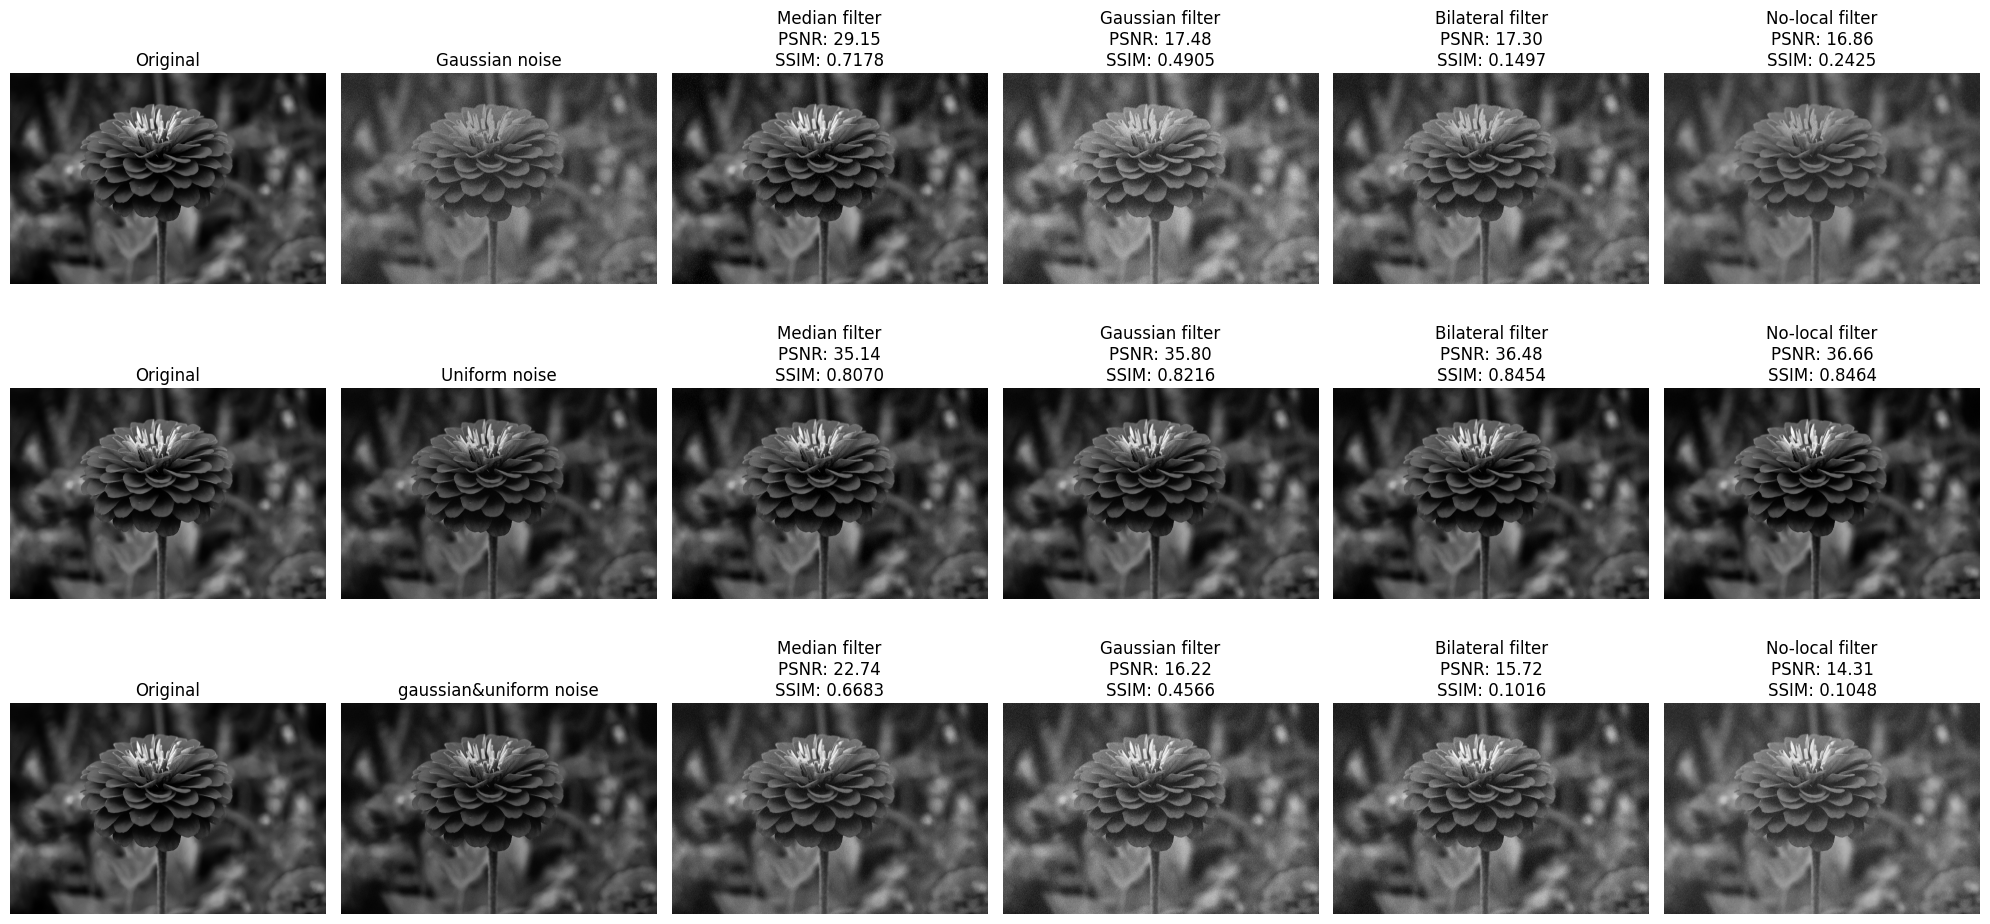


RESULTS:
--------------------------------------------------------------------------------
The best filter for gaussian noise: Median (gaussian noise, kernel=9)
  PSNR: 29.15, SSIM: 0.7178

The best filter for uniform noise: No-local Means (uniform noise, h=20, template=7, search=21)
  PSNR: 36.66, SSIM: 0.8464

The best filter for gaussian&uniform noise: Median (gaussian&uniform noise, kernel=9)
  PSNR: 22.74, SSIM: 0.6683


In [16]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

# Gaussian noise
axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_noise_gauss, cmap='gray')
axes[0, 1].set_title('Gaussian noise')
axes[0, 1].axis('off')

# Best results for gaussian noise
best_gaussian = {}
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    if noise_type == "gaussian":
        best_gaussian[filter_type] = results[key][0]

row = 0
col = 2
for filter_type, filtered_img in best_gaussian.items():
    axes[row, col].imshow(filtered_img, cmap='gray')
    axes[row, col].set_title(f'{filter_type} filter\nPSNR: {best_results[("gaussian", filter_type)][1]:.2f}\nSSIM: {best_results[("gaussian", filter_type)][2]:.4f}')
    axes[row, col].axis('off')
    col += 1

# Uniform noise
axes[1, 0].imshow(image_gray, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(image_noise_uniform, cmap='gray')
axes[1, 1].set_title('Uniform noise')
axes[1, 1].axis('off')

# Best results for uniform noise
best_unif = {}
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    if noise_type == "uniform":
        best_unif[filter_type] = results[key][0]

row = 1
col = 2
for filter_type, filtered_img in best_unif.items():
    axes[row, col].imshow(filtered_img, cmap='gray')
    axes[row, col].set_title(f'{filter_type} filter\nPSNR: {best_results[("uniform", filter_type)][1]:.2f}\nSSIM: {best_results[("uniform", filter_type)][2]:.4f}')
    axes[row, col].axis('off')
    col += 1

# Gaussian & Uniform noise
axes[2, 0].imshow(image_gray, cmap='gray')
axes[2, 0].set_title('Original')
axes[2, 0].axis('off')

axes[2, 1].imshow(image_noise_uniform, cmap='gray')
axes[2, 1].set_title('gaussian&uniform noise')
axes[2, 1].axis('off')

# Best results for gaussian & uniform noise
best_gauss_unif = {}
for (noise_type, filter_type), (key, psnr_val, ssim_val) in best_results.items():
    if noise_type == "gaussian&uniform":
        best_gauss_unif[filter_type] = results[key][0]

row = 2
col = 2
for filter_type, filtered_img in best_gauss_unif.items():
    axes[row, col].imshow(filtered_img, cmap='gray')
    axes[row, col].set_title(f'{filter_type} filter\nPSNR: {best_results[("gaussian&uniform", filter_type)][1]:.2f}\nSSIM: {best_results[("gaussian&uniform", filter_type)][2]:.4f}')
    axes[row, col].axis('off')
    col += 1

plt.tight_layout()
plt.show()

# Best overall
best_gauss_overall = max([(key, psnr, ssim) for (noise_type, filter_type), (key, psnr, ssim) in best_results.items() if noise_type == "gaussian"], key=lambda x: x[1])
best_unif_overall = max([(key, psnr, ssim) for (noise_type, filter_type), (key, psnr, ssim) in best_results.items() if noise_type == "uniform"], key=lambda x: x[1])
best_gauss_unif_overall = max([(key, psnr, ssim) for (noise_type, filter_type), (key, psnr, ssim) in best_results.items() if noise_type == "gaussian&uniform"], key=lambda x: x[1])

print("\nRESULTS:")
print("-" * 80)
print(f"The best filter for gaussian noise: {best_gauss_overall[0]}")
print(f"  PSNR: {best_gauss_overall[1]:.2f}, SSIM: {best_gauss_overall[2]:.4f}")
print()
print(f"The best filter for uniform noise: {best_unif_overall[0]}")
print(f"  PSNR: {best_unif_overall[1]:.2f}, SSIM: {best_unif_overall[2]:.4f}")
print()
print(f"The best filter for gaussian&uniform noise: {best_gauss_unif_overall[0]}")
print(f"  PSNR: {best_gauss_unif_overall[1]:.2f}, SSIM: {best_gauss_unif_overall[2]:.4f}")